# Оценка точности модели, переобучение, регуляризация

### Преобразование данных

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [4]:
data.isna().sum()

id               0
name             0
nationality      0
sex              0
dob              1
height         330
weight         659
sport            0
gold             0
silver           0
bronze           0
dtype: int64

In [5]:
data[["height"]].value_counts()

height
1.80      580
1.70      579
1.75      484
1.78      453
1.73      424
         ... 
1.42        1
1.40        1
1.38        1
1.34        1
2.21        1
Length: 82, dtype: int64

In [6]:
data[["weight"]].value_counts()

weight
70.0      482
60.0      387
65.0      382
75.0      342
58.0      336
         ... 
146.0       1
133.0       1
134.0       1
137.0       1
31.0        1
Length: 123, dtype: int64

Удалим все значения где одновременно пусты и weight и height.

In [7]:
almost_clean_data = data[data['weight'].notna() | data['height'].notna()]
almost_clean_data

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


Можно заметить что строка с путсым значением dob исчезла. И мы избавились от 309 строк.

In [8]:
almost_clean_data.isna().sum()

id               0
name             0
nationality      0
sex              0
dob              0
height          21
weight         350
sport            0
gold             0
silver           0
bronze           0
dtype: int64

In [9]:
almost_clean_data.describe()

,id,height,weight,gold,silver,bronze
count,1.122900e+04,11208.000000,10879.000000,11229.000000,11229.000000,11229.000000
mean,4.999163e+08,1.766282,72.068205,0.059044,0.057797,0.062071
std,2.909071e+08,0.112719,16.177334,0.258771,0.240881,0.245323
min,1.834700e+04,1.210000,31.000000,0.000000,0.000000,0.000000
25%,2.450891e+08,1.690000,60.000000,0.000000,0.000000,0.000000
50%,4.996032e+08,1.760000,70.000000,0.000000,0.000000,0.000000
75%,7.537477e+08,1.840000,81.000000,0.000000,0.000000,0.000000
max,9.999878e+08,2.210000,170.000000,5.000000,2.000000,2.000000


Можно посмотреть на выбросы по столбцу weight. Получилось что между первой и третьей q вошло 5851 значенй, что урезает датасет вдвое. Поэтому этого делать не будем.

In [10]:
iqr = almost_clean_data['weight'][almost_clean_data['weight'].between(almost_clean_data['weight'].quantile(.25), almost_clean_data['weight'].quantile(.75), inclusive=True)]
iqr

<ipython-input-10-345ae88a25cc>:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  iqr = almost_clean_data['weight'][almost_clean_data['weight'].between(almost_clean_data['weight'].quantile(.25), almost_clean_data['weight'].quantile(.75), inclusive=True)]


0        64.0
2        79.0
3        80.0
4        71.0
5        67.0
         ... 
11530    70.0
11531    75.0
11532    68.0
11534    63.0
11537    70.0
Name: weight, Length: 5851, dtype: float64

Посмотрим на средние значения параметров для наших колонок. Можно заметить что люди у которых не заполнен вес чаще получали бронзу относительного среднего значения, а те люди у которых не заполнен рост вообще не получали золото. (Предположительно) Это нам ничего не дает. Идем дальше.

In [11]:
almost_clean_data.groupby(almost_clean_data['weight'].isnull()).mean()

,id,height,weight,gold,silver,bronze
weight,,,,,,
False,5.010672e+08,1.766942,72.068205,0.059656,0.058461,0.058553
True,4.641419e+08,1.745800,NaN,0.040000,0.037143,0.171429


In [12]:
almost_clean_data.groupby(almost_clean_data['height'].isnull()).mean()

,id,height,weight,gold,silver,bronze
height,,,,,,
False,4.999777e+08,1.766282,72.070915,0.059154,0.057816,0.062099
True,4.671292e+08,NaN,70.666667,0.000000,0.047619,0.047619


Посмотрим на датасет в котором веса нулевые. В этом датасете нам известен факт что все значения столбца height по этим весам не нулевые. Поэтому мы можем для каждого пустого значения столбца weight расчитать его среднее на основе соответсвующего значения height. То есть мы не будем задавать 350 строкам значение среднее по датасету, вместо этого для каждой строки найдем средний вес по росту и запишем это значение.

In [13]:
almost_clean_data[almost_clean_data['weight'].isna()]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
28,349871091,Abdelhafid Benchabla,ALG,male,9/26/86,1.86,NaN,boxing,0,0,0
30,23564778,Abdelkader Chadi,ALG,male,12/12/86,1.78,NaN,boxing,0,0,0
37,934545704,Abdelrahman Salah Orabi Abdelgawwad,EGY,male,10/9/87,1.85,NaN,boxing,0,0,0
53,101781750,Abdulkadir Abdullayev,AZE,male,7/17/88,1.88,NaN,boxing,0,0,0
57,153457,Abdullahi Shehu,NGR,male,3/12/93,1.70,NaN,football,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
11465,980866226,Zhaina Shekerbekova,KAZ,female,12/17/89,1.54,NaN,boxing,0,0,0
11468,405483135,Zhanibek Alimkhanuly,KAZ,male,4/1/93,1.82,NaN,boxing,0,0,0
11513,352983859,Zohir Kedache,ALG,male,3/2/86,1.78,NaN,boxing,0,0,0
11514,424586991,Zohra Ez Zahraoui,MAR,female,11/18/83,1.65,NaN,boxing,0,0,0


Посмотрим на средний вес для двух разных значений height. Видим что weight различается.

In [14]:
almost_clean_data[almost_clean_data["height"] == 1.86].mean()

<ipython-input-14-07d532059b32>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  almost_clean_data[almost_clean_data["height"] == 1.86].mean()


id        4.889016e+08
height    1.860000e+00
weight    8.299678e+01
gold      7.570978e-02
silver    6.624606e-02
bronze    6.309148e-02
dtype: float64

In [15]:
almost_clean_data[almost_clean_data["height"] == 1.78].mean()

<ipython-input-15-b5aa0a116456>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  almost_clean_data[almost_clean_data["height"] == 1.78].mean()


id        5.020828e+08
height    1.780000e+00
weight    7.297936e+01
gold      5.518764e-02
silver    5.739514e-02
bronze    5.960265e-02
dtype: float64

Сделаем копию датафрейма для теста

In [16]:
test_almost_clean_data = almost_clean_data.copy()

Заметка[1] - Оказывается всегда надо ставить скобки в условиях с and or.

Давайте попробуем заменить один из весов принадлежащий росту 1.86 на среднее значение по этому росту.

In [17]:
almost_clean_data[(almost_clean_data['weight'].isna()) & (almost_clean_data["height"] == 1.86)]["weight"]

28     NaN
5187   NaN
5239   NaN
7690   NaN
9285   NaN
9952   NaN
Name: weight, dtype: float64

In [18]:
index = test_almost_clean_data[(test_almost_clean_data['weight'].isna()) & (test_almost_clean_data["height"] == 1.86)]["weight"].index[0]
print(index)

avg_w = test_almost_clean_data[test_almost_clean_data["height"] == 1.86].mean()["weight"]
print(avg_w)

test_almost_clean_data.loc[index, "weight"] = avg_w

28
82.9967845659164


<ipython-input-18-eef7d2ea5862>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_w = test_almost_clean_data[test_almost_clean_data["height"] == 1.86].mean()["weight"]


Видим что строки с индексом 28 больше нет в выборке. Значит наше новое значение успешно присвоилось. Давайте сделаем теперь это для всего массива.

In [19]:
test_almost_clean_data[(test_almost_clean_data['weight'].isna()) & (test_almost_clean_data["height"] == 1.86)]["weight"]

5187   NaN
5239   NaN
7690   NaN
9285   NaN
9952   NaN
Name: weight, dtype: float64

Посчитаем средний вес для каждого роста где вес нулевой.

In [20]:
not_valid_weight_data = almost_clean_data[almost_clean_data['weight'].isna()]["height"]

for i in not_valid_weight_data:
  index = almost_clean_data[(almost_clean_data['weight'].isna()) & (almost_clean_data["height"] == i)]["weight"].index[0]
  avg_w = almost_clean_data[almost_clean_data["height"] == i].mean()["weight"]

  almost_clean_data.loc[index, "weight"] = avg_w

<ipython-input-20-52b232e64c08>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_w = almost_clean_data[almost_clean_data["height"] == i].mean()["weight"]
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Мы избавились от всех нулевых значений для weight. Повторим тоже самое для height

In [21]:
almost_clean_data.isna().sum()

id              0
name            0
nationality     0
sex             0
dob             0
height         21
weight          0
sport           0
gold            0
silver          0
bronze          0
dtype: int64

In [22]:
not_valid_height_data = almost_clean_data[almost_clean_data['height'].isna()]["weight"]

for i in not_valid_height_data:
  index = almost_clean_data[(almost_clean_data['height'].isna()) & (almost_clean_data["weight"] == i)]["height"].index[0]
  avg_h = almost_clean_data[almost_clean_data["weight"] == i].mean()["height"]

  almost_clean_data.loc[index, "height"] = avg_h

<ipython-input-22-82f6aeb55c17>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_h = almost_clean_data[almost_clean_data["weight"] == i].mean()["height"]


Мы полностью избавились от пустых данных.

In [23]:
almost_clean_data.isna().sum()

id             0
name           0
nationality    0
sex            0
dob            0
height         0
weight         0
sport          0
gold           0
silver         0
bronze         0
dtype: int64

In [24]:
almost_clean_data = almost_clean_data.reset_index()

### Метрики

##### Выбор Y

In [51]:
test_df = almost_clean_data.copy()
test_df

,index,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11224,11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11225,11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11226,11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11227,11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


Посмотрим сколько спорстменов из 11229 имеют медали. Как мы видим из вывода ниже - всего 1865 участников имеют какую-либо медаль, что очень мало относительно целого датасета. Получается предсказывать наличие той или иной медали будет не корректно из-за неравномерного распределения данных по классам. Как вариант можно было бы взять только те строки по которым имеются медали. (Правильно?)

In [52]:
test_df.set_index('index',inplace=True)
res = test_df[test_df==1].stack().reset_index().drop(0, axis=1)
res

,index,level_1
0,2,bronze
1,6,bronze
2,14,gold
3,14,silver
4,48,silver
...,...,...
1860,11487,gold
1861,11491,silver
1862,11503,gold
1863,11509,silver


In [53]:
res["level_1"].value_counts()

bronze    675
silver    609
gold      581
Name: level_1, dtype: int64

Тогда будем предсказывать пол на основе веса и роста

In [54]:
sex_df = pd.get_dummies(almost_clean_data, columns=['sex'], drop_first=True)
sex_df

,index,id,name,nationality,dob,height,weight,sport,gold,silver,bronze,sex_male
0,0,736041664,A Jesus Garcia,ESP,10/17/69,1.72,64.0,athletics,0,0,0,1
1,1,532037425,A Lam Shin,KOR,9/23/86,1.68,56.0,fencing,0,0,0,0
2,2,435962603,Aaron Brown,CAN,5/27/92,1.98,79.0,athletics,0,0,1,1
3,3,521041435,Aaron Cook,MDA,1/2/91,1.83,80.0,taekwondo,0,0,0,1
4,4,33922579,Aaron Gate,NZL,11/26/90,1.81,71.0,cycling,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11224,11533,265605954,Zurian Hechavarria,CUB,8/10/95,1.64,58.0,athletics,0,0,0,0
11225,11534,214461847,Zuzana Hejnova,CZE,12/19/86,1.73,63.0,athletics,0,0,0,0
11226,11535,88361042,di Xiao,CHN,5/14/91,1.85,100.0,wrestling,0,0,0,1
11227,11536,900065925,le Quoc Toan Tran,VIE,4/5/89,1.60,56.0,weightlifting,0,0,0,1


In [55]:
X = sex_df[["height", "weight"]]
X

,height,weight
0,1.72,64.0
1,1.68,56.0
2,1.98,79.0
3,1.83,80.0
4,1.81,71.0
...,...,...
11224,1.64,58.0
11225,1.73,63.0
11226,1.85,100.0
11227,1.60,56.0


In [56]:
Y = sex_df["sex_male"]
Y

0        1
1        0
2        1
3        1
4        1
        ..
11224    0
11225    0
11226    1
11227    1
11228    1
Name: sex_male, Length: 11229, dtype: uint8

##### Вычисление метрок через библиотеки

Разделим датасет так что 80% - обучающая выборка, 20% - тестовая

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Обучим логистическую регрессию

In [58]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [59]:
predictions = model.predict_proba(X_test)

Просчитаем значения для ROC кривой

In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, roc_thres = roc_curve(Y_test, predictions[:, 1])

In [61]:
list(zip(fpr, tpr))[:5]

[(0.0, 0.0),
 (0.0, 0.0008210180623973727),
 (0.0, 0.009852216748768473),
 (0.0009727626459143969, 0.009852216748768473),
 (0.0009727626459143969, 0.011494252873563218)]

Построим график ROC кривой. По нему видно что мы имеем хорошую выпуклость. ROC кривая не слишком близка к диагонали.

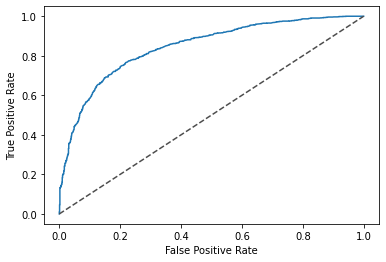

In [62]:
from matplotlib import pyplot as plt

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", c=".3")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

Посчитаем метрику. 0.84 результат для обучающего датасета вполне хорош

In [63]:
roc_auc_score(Y_test, predictions[:, 1])

0.8447808648482873

##### Вычисление метрок вручную

Сделаем метод для расчета значений ROC кривой.

In [64]:
import numpy as np

def my_roc_curve(Y, Y_prob, thresholds):
    fpr, tpr = [], []

    for threshold in thresholds:
        Y_pred = np.where(Y_prob >= threshold, 1, 0)

        fp = np.sum((Y_pred == 1) & (Y == 0))
        tp = np.sum((Y_pred == 1) & (Y == 1))
        fn = np.sum((Y_pred == 0) & (Y == 1))
        tn = np.sum((Y_pred == 0) & (Y == 0))

        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))

    return [fpr, tpr]

Проведем расчет и сравним результаты вывода первых 5 значений fpr и tpr между расчетом произведенным sklearn и ручным расчетом. Видим что значения идентичны.

In [65]:
ans = my_roc_curve(Y_test, predictions[:, 1], roc_thres)

In [66]:
list(zip(ans[0], ans[1]))[:5]

[(0.0, 0.0),
 (0.0, 0.0008210180623973727),
 (0.0, 0.009852216748768473),
 (0.0009727626459143969, 0.009852216748768473),
 (0.0009727626459143969, 0.011494252873563218)]

Можно построить график ROC кривой на своих данных и визуально заметить что графики похожи. Давайте построим обе кривые на одном графике и посмотрим на них.

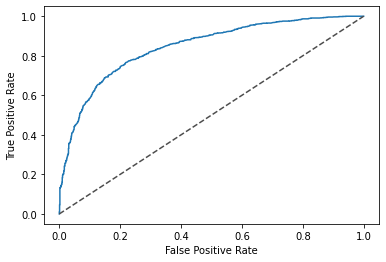

In [67]:
plt.plot(ans[0], ans[1])
plt.plot([0, 1], [0, 1], ls="--", c=".3")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

Видно что графики покрывают друг друга => они идентичны. Значит наш расчет верный.

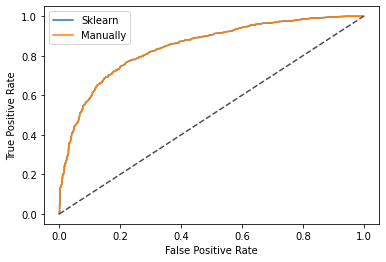

In [68]:
plt.plot(fpr, tpr, label='Sklearn')
plt.plot(ans[0], ans[1], label='Manually')
plt.plot([0, 1], [0, 1], ls="--", c=".3")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=0)
plt.show()

Посчитаем precision_recall кривую с помощью sklearn

In [69]:
from sklearn.metrics import precision_recall_curve

pr, re, thres = precision_recall_curve(Y_test, predictions[:, 1])

In [70]:
list(zip(pr, re))[:5]

[(0.5569272976680384, 1.0),
 (0.5567246111619396, 0.9991789819376026),
 (0.5572344322344323, 0.9991789819376026),
 (0.5574896930829134, 0.9991789819376026),
 (0.5577451879010082, 0.9991789819376026)]

Сделаем собственную функцию для расчета значений precision_recall кривой

In [71]:
def my_precision_recall_curve(Y, Y_prob, thresholds):
    precision, recall = [], []

    for threshold in thresholds:
        Y_pred = np.where(Y_prob >= threshold, 1, 0)

        fp = np.sum((Y_pred == 1) & (Y == 0))
        tp = np.sum((Y_pred == 1) & (Y == 1))
        fn = np.sum((Y_pred == 0) & (Y == 1))

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))

    return [precision, recall]

In [72]:
precision, recall = my_precision_recall_curve(Y_test, predictions[:, 1], thres) 

По результатам расчетов видно что первые 5 значений идентичны. Давайте построим график

In [73]:
list(zip(precision, recall))[:5]

[(0.5569272976680384, 1.0),
 (0.5567246111619396, 0.9991789819376026),
 (0.5572344322344323, 0.9991789819376026),
 (0.5574896930829134, 0.9991789819376026),
 (0.5577451879010082, 0.9991789819376026)]

Также как и в предыдущем примере наши графики полностью совпали, что хорошо. На этом графике мы видим зависимость точности от полноты.

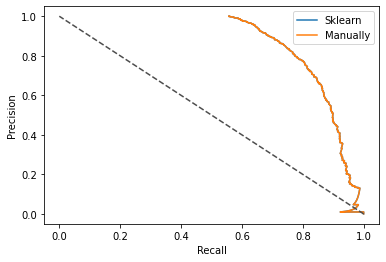

In [74]:
plt.plot(pr, re, label='Sklearn')
plt.plot(precision, recall, label='Manually')
plt.plot([1, 0], [0, 1], ls="--", c=".3")

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc=0)
plt.show()

Просчитав roc_auc через Sklearn я попробовал это сделать своим способом. Но есть минусы.

1) Этот способ не правильный на сколько я понимаю. Но если у нас достаточно много tresholds то значение того что я просчитал будет стремиться к правильному значению.


2) Roc_auc нужно считать через интегралы или для этого есть более хитрый метод?

In [75]:
roc_auc_score(Y_test, predictions[:, 1])

0.8447808648482873

In [76]:
sum(precision) / len(precision)

0.8149398289399374

### Выводы

##### Как по полученным графикам сделать вывод о качестве модели?

Нужно измерить площадь под фигурой. Чем площадь выше тем лучше. Или же чем кривая больше прилегает к оси Y и к прямой Y=1 тем результат лучше. НО на реальных данных кривая никогда не будет полность юприлегать к этим прямым.

##### Как вы оцениваете обученную модель исходя из подсчитанных метрик?

Сложно сказать хорошая или плохая модель не сравнивая её с другими алгоритмами/моделями/подходами на этих данных для получения лучшего рещультата. Но в целом модель выдает хороший результат. 0.84%

##### Может ли ROC-кривая проходить ниже диагонали?

Поидее если ROC кривая близка к диагонали то это плохая модель которая при бинарной классификации рандомно угадывает правильный ответ (с вероятностью 50%). А если ниже кривой то процент еще хуже. НО вполне может оказаться, что если кривая ниже диагонали, то данные нужно инвертировать

Но если честно не совсем понятно в каких случаях такое возникает. Если есть ссылка где это можно почитать было бы отлично

В целом в данной работе повторил навыки чистки и обработки данных - а также разобрался в новых метриках, научился их вычислять самостоятельно и строить на основе этих данных графики и видеть зависимости